In [27]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patheffects as PathEffects
from PIL import Image, ImageDraw, ImageOps
%matplotlib inline
import seaborn as sns
import random
import os
import gc

from sklearn.manifold import TSNE
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models, Sequential
from tensorflow.keras import optimizers

from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D

from tensorflow.keras.applications.vgg16 import VGG16

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

In [28]:
#file path for our train data and test data
train_dir = r"C:\Users\91809\Desktop\ARKS\05_ARKS_Early-Prediction-of-Autism-Disorder\AutismDataset\train"
test_dir = r"C:\Users\91809\Desktop\ARKS\05_ARKS_Early-Prediction-of-Autism-Disorder\AutismDataset\test"

In [29]:
train_non_autistic = []
train_autistic = []
for i in os.listdir(train_dir):
    if 'Non_Autistic' in (r"C:\Users\91809\Desktop\ARKS\05_ARKS_Early-Prediction-of-Autism-Disorder\AutismDataset\train\{}".format(i)):
        train_non_autistic.append((r"C:\Users\91809\Desktop\ARKS\05_ARKS_Early-Prediction-of-Autism-Disorder\AutismDataset\train\{}".format(i)))
    else:
        train_autistic.append((r"C:\Users\91809\Desktop\ARKS\05_ARKS_Early-Prediction-of-Autism-Disorder\AutismDataset\train\{}".format(i)))
        
# Getting test images from test data file path
test_imgs = [r"C:\Users\91809\Desktop\ARKS\05_ARKS_Early-Prediction-of-Autism-Disorder\AutismDataset\test\{}".format(i) for i in os.listdir(test_dir)]


# Concatenate 'Autistic'  and 'Non-Autistic' images and shuffle them as train_images
train_imgs = train_autistic + train_non_autistic
random.shuffle(train_imgs)

# Remove the lists to save space
del train_autistic
del train_non_autistic
gc.collect()

16

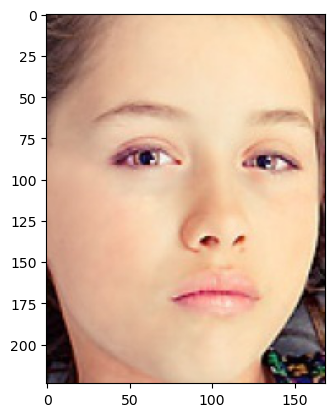

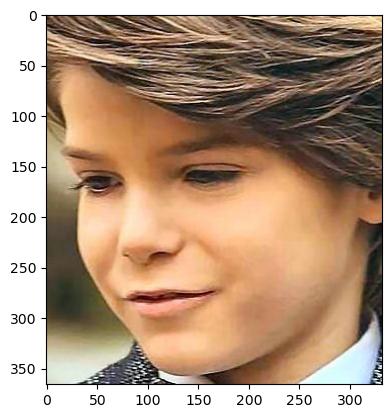

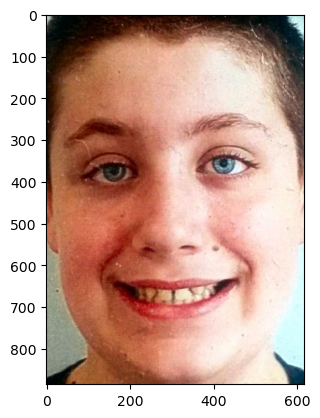

In [30]:
# Plot first 3 images from train_imgs
import matplotlib.image as mpimg
for ima in train_imgs[0:3]:
    img=mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

In [31]:
nrows = 150
ncolumns  = 150
channels = 3

# Read and process the images: Function returns X,y. X - list of resized images, y - list of labels for the images

def read_and_process_image(list_of_images):
    X = []
    y = []
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncolumns), interpolation = cv2.INTER_CUBIC))
        if 'Non_Autistic' in image:
            y.append(0)
        else:
            y.append(1)
            
    return X,y

In [32]:
X_train, y_train = read_and_process_image(train_imgs)

In [33]:
sns.set_palette(sns.color_palette(["b", "r"]))
plt.figure(figsize=(12, 8))
X_train = np.array(X_train)
y_train = np.array(y_train)

<Figure size 1200x800 with 0 Axes>

In [34]:
# Function for pre-processing images for input to t-sne algorithm
def process_data_tsne(list_of_images):
        
    nrows = 150
    ncolumns  = 150
    channels = 3
    
    X = []
    y = []
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.COLOR_BGR2GRAY), (nrows, ncolumns)))
        if 'Non_Autistic' in image:
            y.append(0)
        else:
            y.append(1)
            
    X = np.asarray(X)
    y = np.asarray(y)
    X = X.reshape(2540, 150*150*3)
    
    return X,y


In [35]:
features, labels = process_data_tsne(train_imgs)

In [36]:
tsne = TSNE(random_state=42).fit_transform(features)

In [37]:
def visualise_tsne_3d(tsne_data, target):
    colour_map = []
    for i in target:
        if i == 1:
            colour_map.append('r')
        else:
            colour_map.append('b')

    fig = plt.figure(figsize=(18, 18))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*zip(*tsne), c=colour_map, s=30, alpha=1)
    legenditems = [(plt.Rectangle((0,0),1,1, color=c), "Non_Autistic" if str(i) == '0' else "Autistic") for i,c in enumerate(np.unique(colour_map))]
    plt.legend(*zip(*legenditems))
    plt.show()

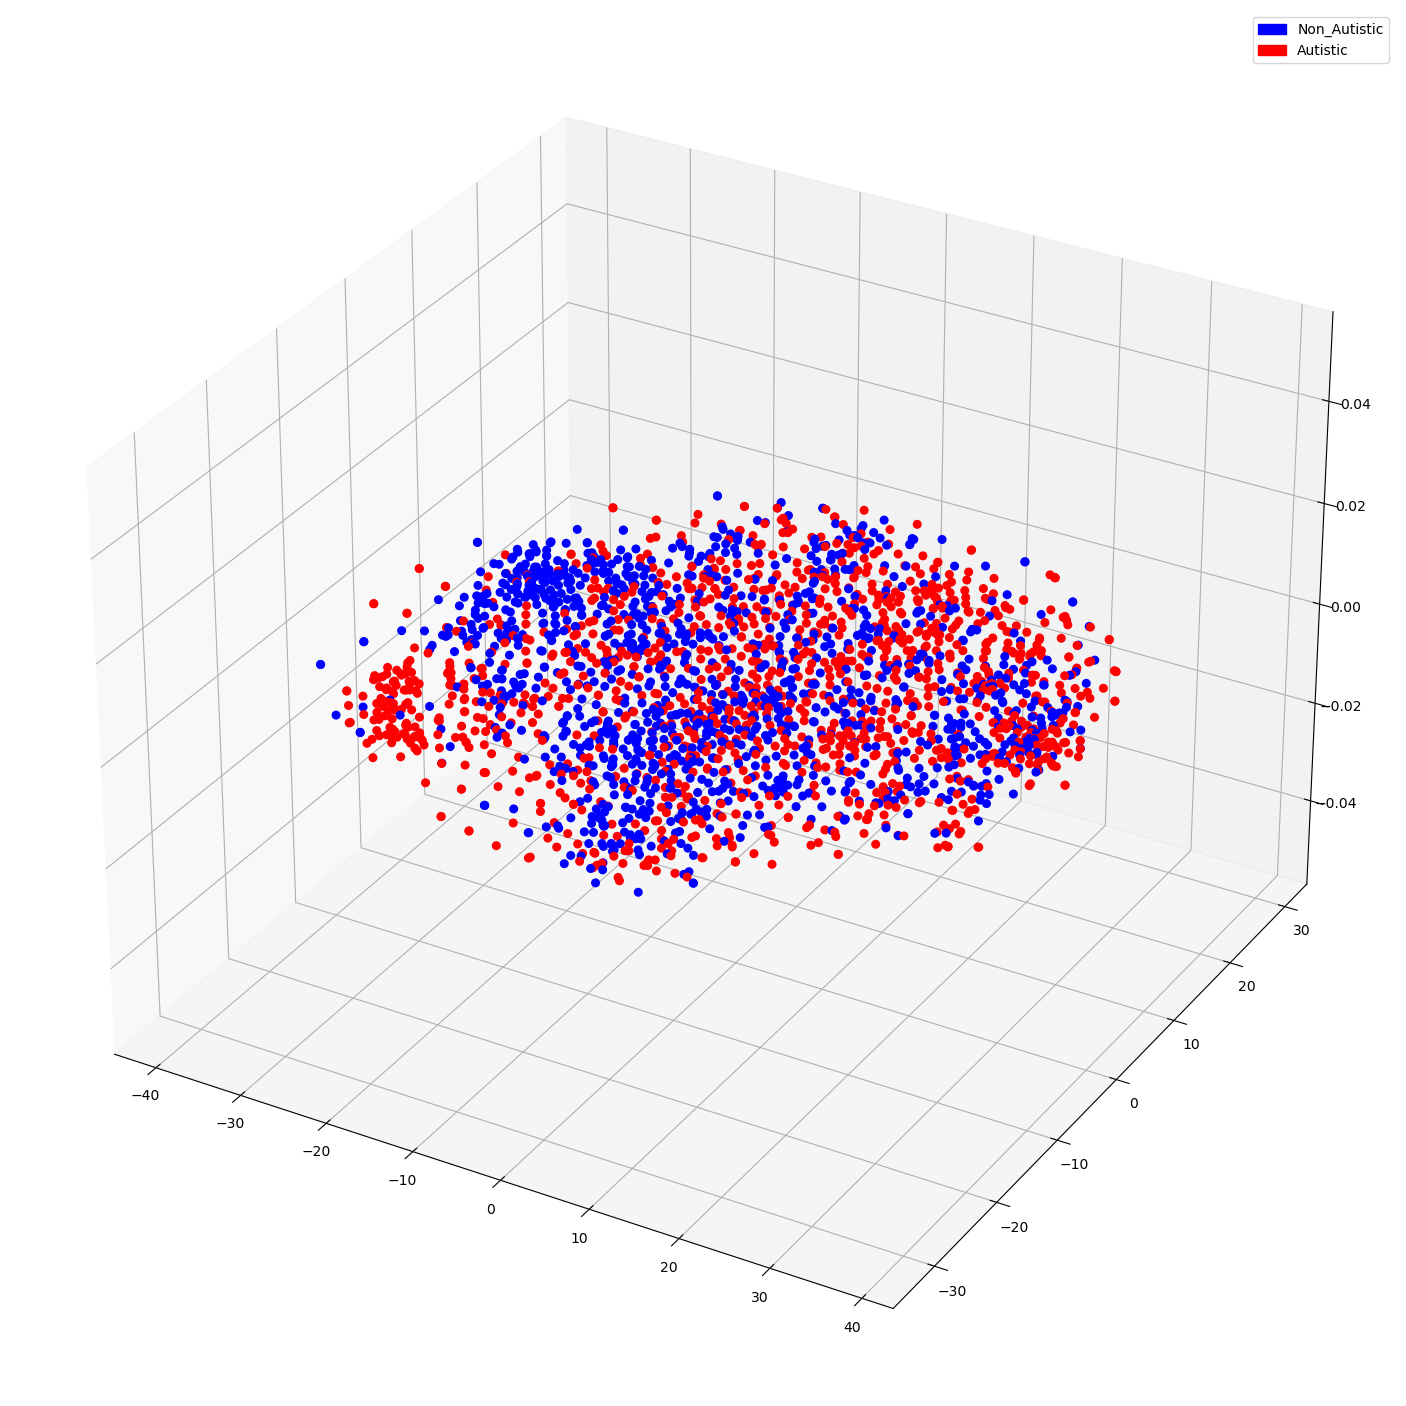

In [38]:
visualise_tsne_3d(tsne, labels)

In [39]:
def visualise_tsne_datapoints(tsne_data, labels):
       
    tx = tsne_data[:,0]
    ty = tsne_data[:,1]
    plt.figure(figsize=(20,18))
    sns.scatterplot(
    x=tx, y=ty,
    hue=labels,
    palette=['blue', 'red'],
    s=300, 
    legend='auto'
    )

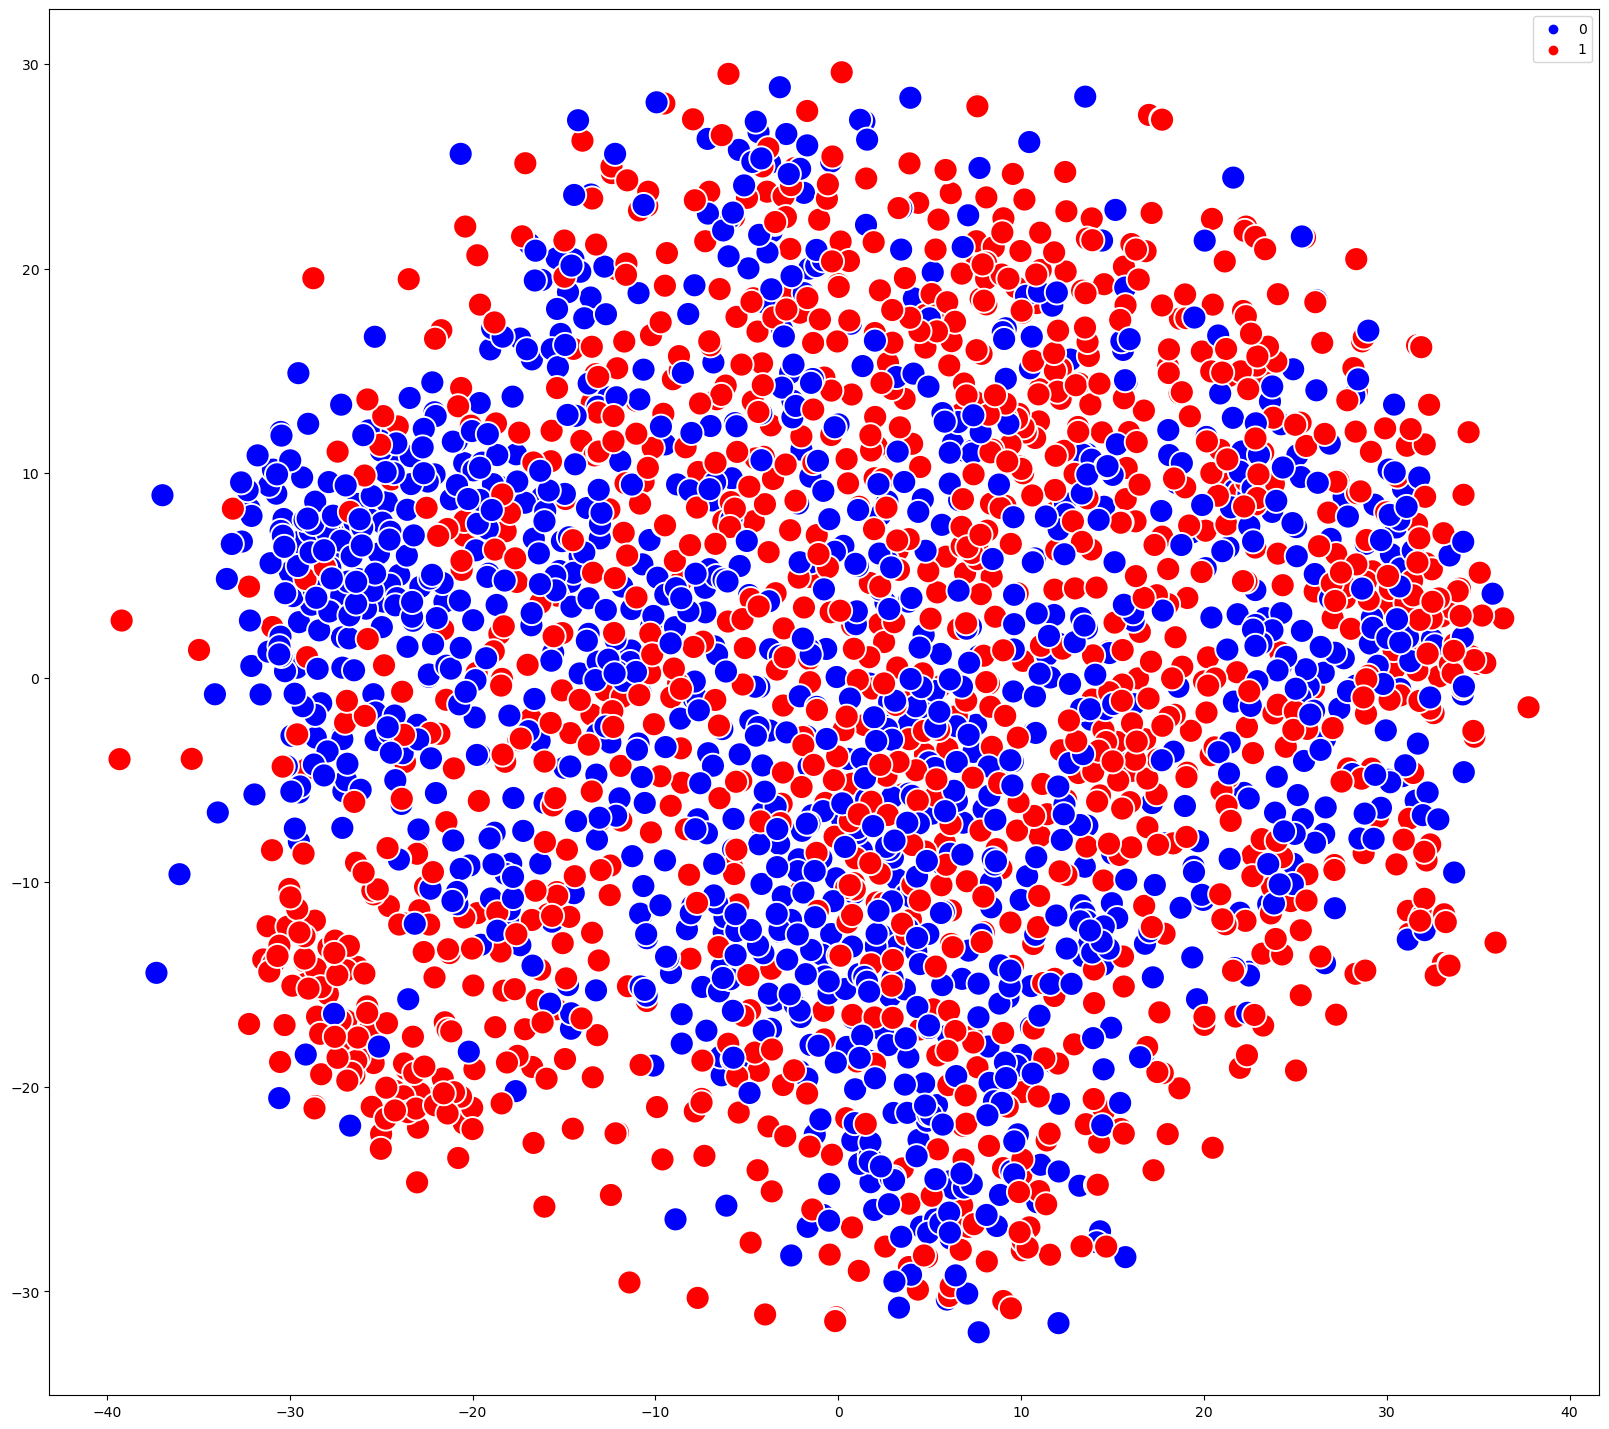

In [40]:
visualise_tsne_datapoints(tsne,labels)

In [41]:
def visualise_tsne_images(tsne_data, train_images, labels):
    
   
    
    tx = tsne_data[:,0]
    ty = tsne_data[:,1]
    image_paths = [train_images[i] for i in range(len(train_images))]
    #label = y_train

    tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
    ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

    width = 4000
    height = 3000
    max_dim = 200

    full_image = Image.new('RGBA', (width, height))
    for img, x, y, label in zip(image_paths, tx, ty, labels):
        tile = Image.open(img)
        rs = max(1, tile.width/max_dim, tile.height/max_dim)
        tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
        tile_height, tile_width = tile.size
        draw = ImageDraw.Draw(tile)
        draw.rectangle((0,0,tile_height-1,tile_width-1), fill=None, outline='blue' if label==0 else 'red', width=8)
        full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*(1-y))), mask=tile.convert('RGBA'))   
    plt.figure(figsize = (30,28))
    plt.imshow(full_image)


C:\Users\91809\AppData\Local\Temp\ipykernel_4772\1209769315.py:21: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)


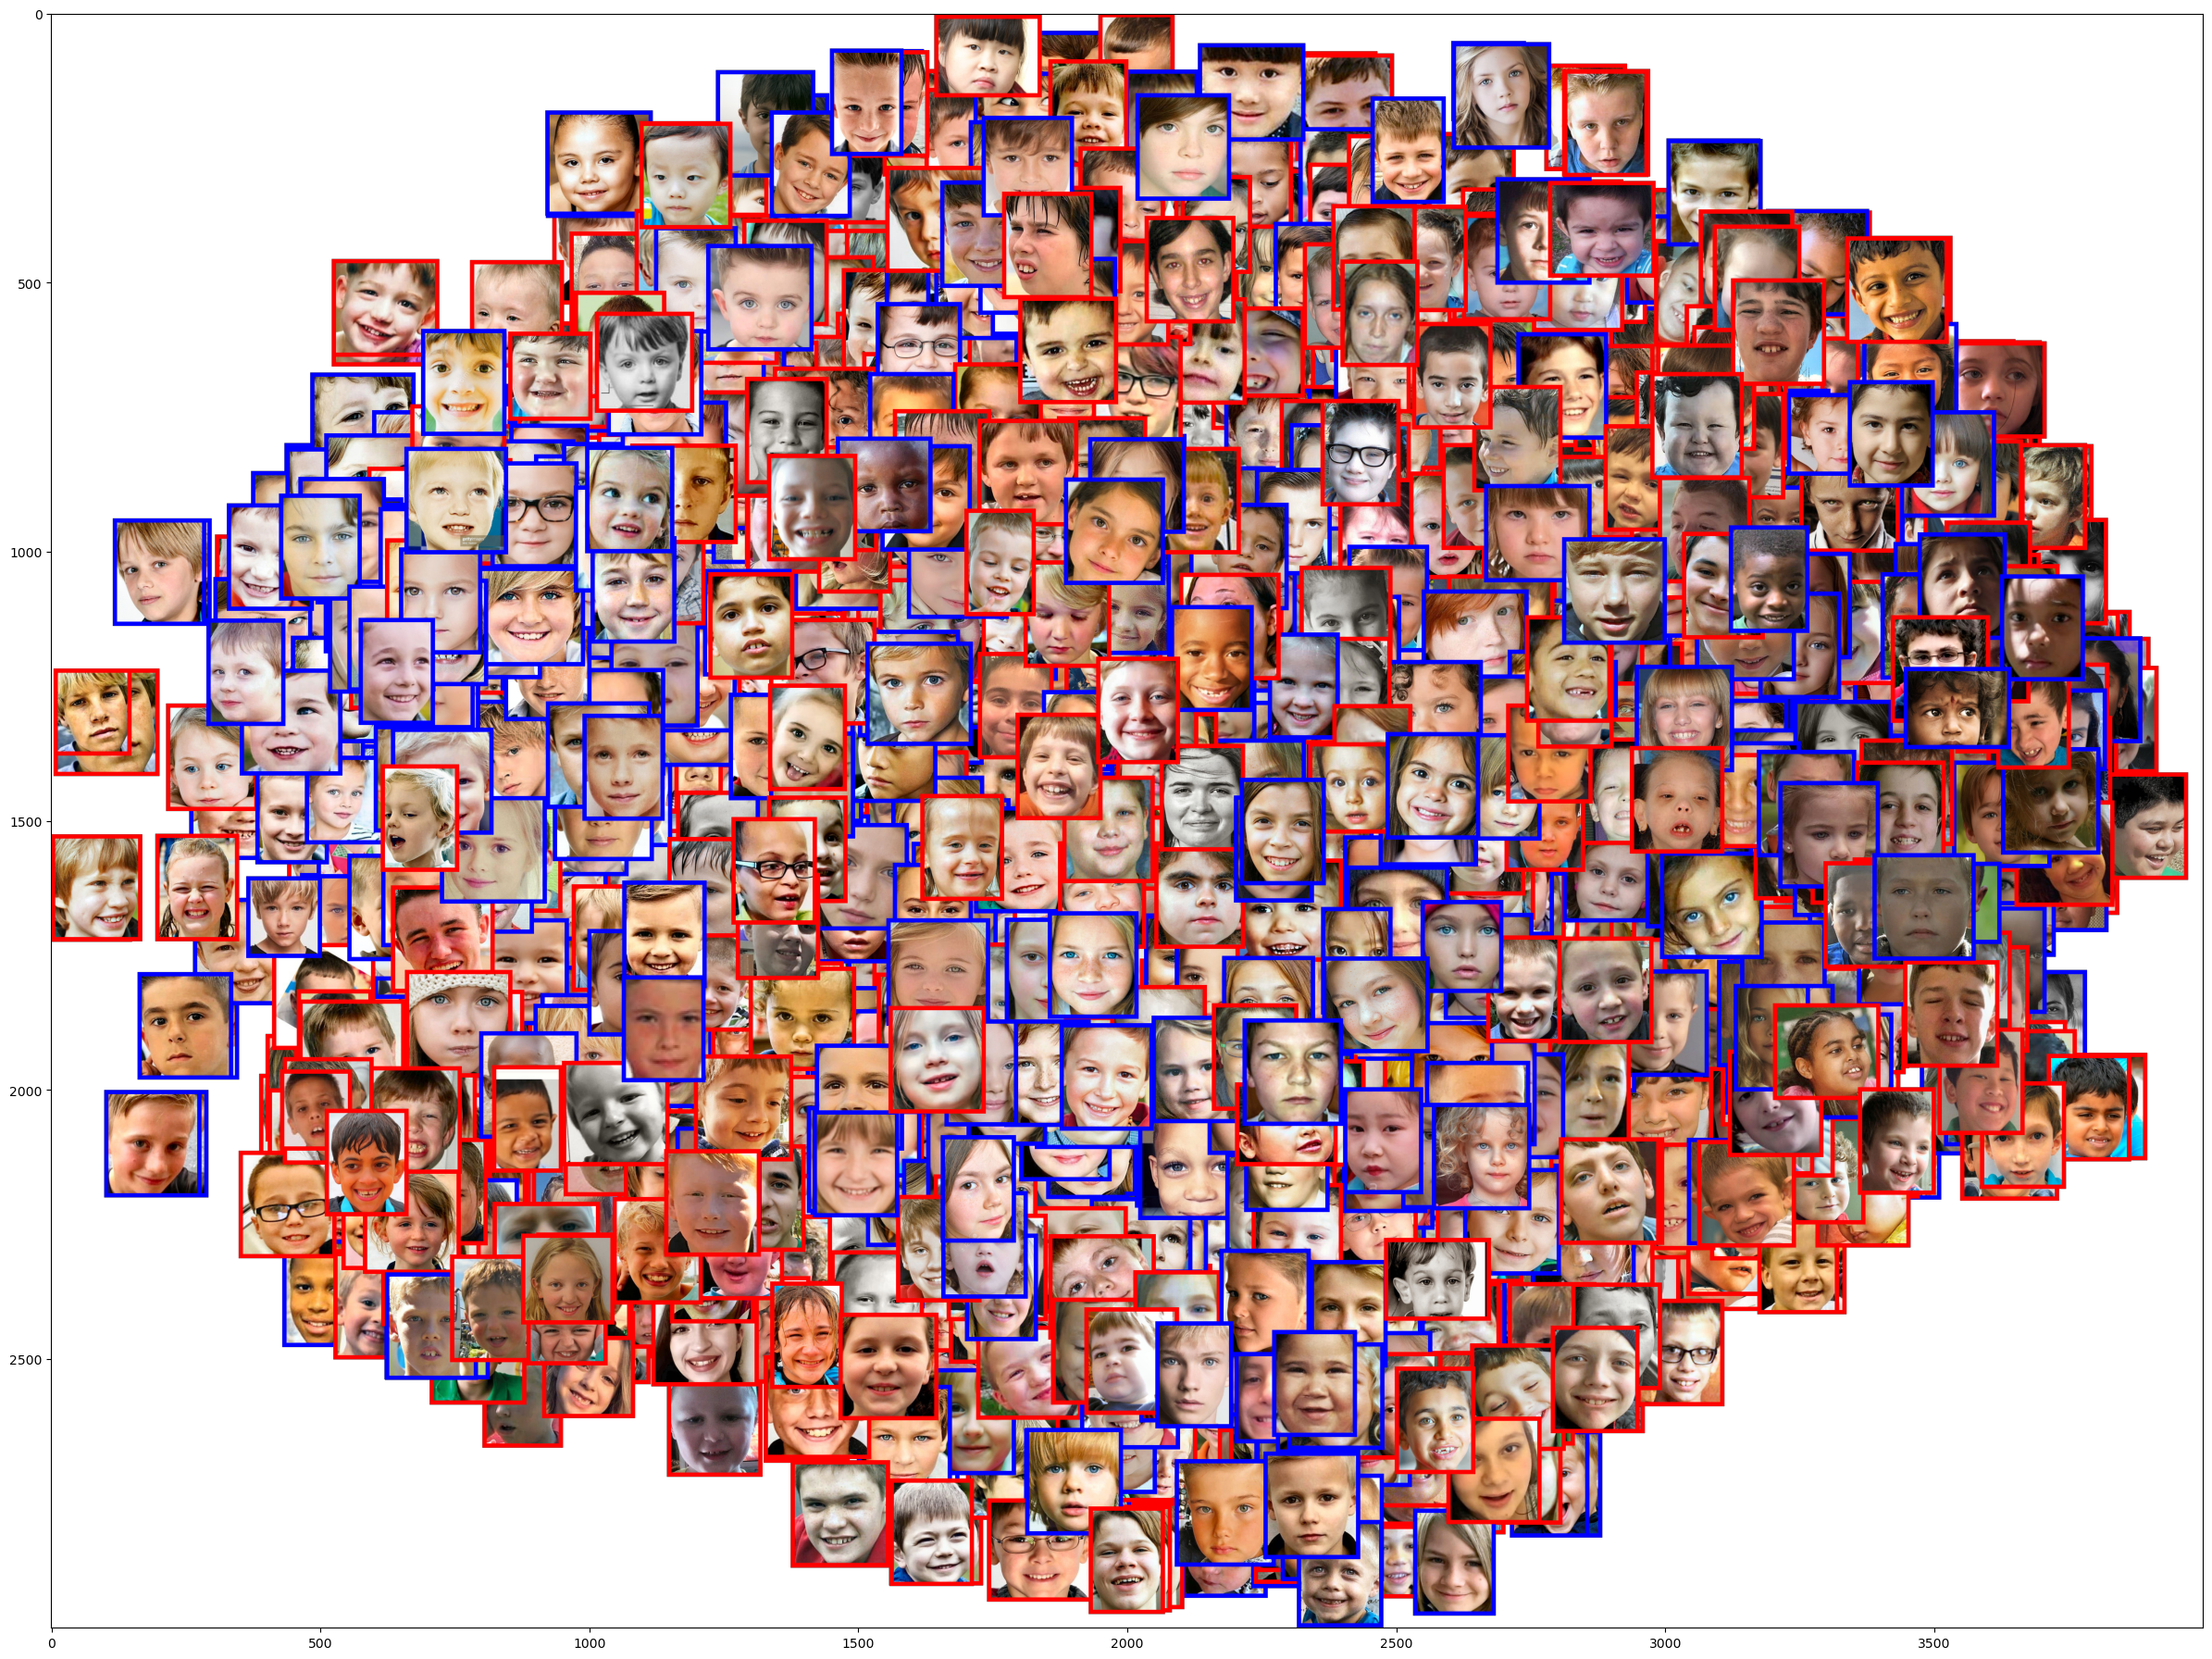

In [42]:

visualise_tsne_images(tsne, train_imgs, labels)

In [43]:
print("Shape of train images:", X_train.shape)
print("Shape of train labels:", y_train.shape)

Shape of train images: (2540, 150, 150, 3)
Shape of train labels: (2540,)


In [44]:
val_autistic = r"C:\Users\91809\Desktop\ARKS\05_ARKS_Early-Prediction-of-Autism-Disorder\AutismDataset\valid\Autistic"
val_non_autistic = r"C:\Users\91809\Desktop\ARKS\05_ARKS_Early-Prediction-of-Autism-Disorder\AutismDataset\valid\Non_Autistic"
val_autistic_imgs = [r"C:\Users\91809\Desktop\ARKS\05_ARKS_Early-Prediction-of-Autism-Disorder\AutismDataset\valid\Autistic\{}".format(i) for i in os.listdir(val_autistic)]
val_non_autistic_imgs = [r"C:\Users\91809\Desktop\ARKS\05_ARKS_Early-Prediction-of-Autism-Disorder\AutismDataset\valid\Non_Autistic\{}".format(i) for i in os.listdir(val_non_autistic)]
val_imgs = val_autistic_imgs + val_non_autistic_imgs
random.shuffle(val_imgs)

# Remove the lists to save space
del val_autistic_imgs
del val_non_autistic_imgs
gc.collect()

15573

In [45]:
X_val, y_val = read_and_process_image(val_imgs)

# Delete validation images to save space
del val_imgs
gc.collect()

4177

Text(0.5, 1.0, 'Validation image labels')

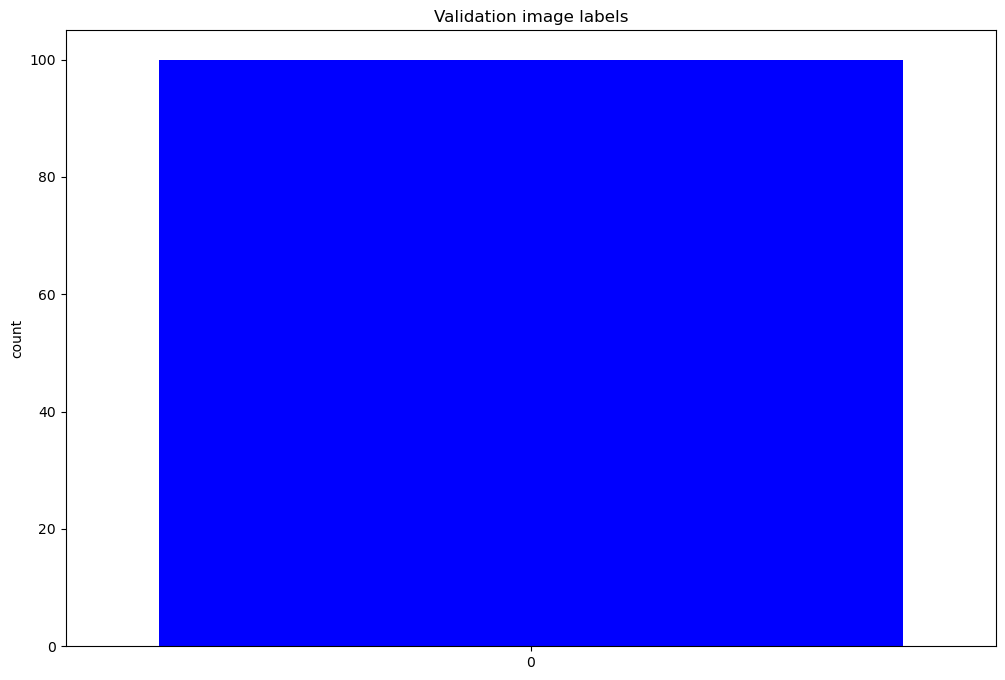

In [46]:
sns.set_palette(sns.color_palette(["b", "r"]))
plt.figure(figsize=(12, 8))
X_val = np.array(X_val)
y_val = np.array(y_val)
sns.countplot(y_val, saturation=1)
plt.title("Validation image labels")

In [47]:
print("Shape of validation images:", X_val.shape)
print("Shape of validation labels:", y_val.shape)

Shape of validation images: (100, 150, 150, 3)
Shape of validation labels: (100,)


In [48]:
ntrain = len(X_train)
nval = len(X_val)
BATCH_SIZE = 32

In [49]:
base_model = VGG16(include_top=False,weights='imagenet',input_shape=(150,150,3))

In [50]:
for layer in base_model.layers:
   layer.trainable = False

In [51]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [52]:
model = keras.models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________


In [54]:
model.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(), metrics = ['acc'])

In [55]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

# Only rescaling for validation data
val_datagen = ImageDataGenerator(rescale = 1./255)

In [58]:
train_generator = train_datagen.flow(X_train, y_train, batch_size = BATCH_SIZE)
val_generator = val_datagen.flow(X_val, y_val, batch_size = BATCH_SIZE)

In [59]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

# Train the model
history = model.fit(train_generator,
                              epochs=30,
                              validation_data=val_generator,
                              callbacks=[early_stopping],
                              workers=4,
                              use_multiprocessing=False
                             )

Epoch 1/30
80/80 [==============================] - 38s 289ms/step - loss: 0.7985 - acc: 0.6390 - val_loss: 0.5455 - val_acc: 0.6900
Epoch 2/30
80/80 [==============================] - 19s 228ms/step - loss: 0.5645 - acc: 0.6992 - val_loss: 0.5226 - val_acc: 0.7600
Epoch 3/30
80/80 [==============================] - 19s 230ms/step - loss: 0.5359 - acc: 0.7240 - val_loss: 0.5161 - val_acc: 0.7300
Epoch 4/30
80/80 [==============================] - 19s 233ms/step - loss: 0.5420 - acc: 0.7240 - val_loss: 0.5254 - val_acc: 0.7200
Epoch 5/30
80/80 [==============================] - 19s 237ms/step - loss: 0.5190 - acc: 0.7398 - val_loss: 0.5277 - val_acc: 0.7400
Epoch 6/30
80/80 [==============================] - 20s 240ms/step - loss: 0.5353 - acc: 0.7323 - val_loss: 0.5145 - val_acc: 0.7400
Epoch 7/30
80/80 [==============================] - 20s 239ms/step - loss: 0.5146 - acc: 0.7445 - val_loss: 0.5137 - val_acc: 0.7400
Epoch 8/30
80/80 [==============================] - 20s 240ms/step - 

In [60]:
history_df = pd.DataFrame(history.history)
history_df

loss       acc  val_loss  val_acc
0   0.798526  0.638976  0.545460     0.69
1   0.564537  0.699213  0.522589     0.76
2   0.535939  0.724016  0.516122     0.73
3   0.541988  0.724016  0.525384     0.72
4   0.518997  0.739764  0.527680     0.74
5   0.535341  0.732283  0.514545     0.74
6   0.514615  0.744488  0.513698     0.74
7   0.522261  0.738189  0.508803     0.75
8   0.509044  0.752756  0.524344     0.73
9   0.521747  0.738189  0.511418     0.74
10  0.494689  0.755906  0.514345     0.72
11  0.490052  0.760630  0.532229     0.71
12  0.500663  0.737795  0.560444     0.71
13  0.508821  0.744094  0.513556     0.74
14  0.490002  0.760630  0.505895     0.74
15  0.489641  0.761417  0.499002     0.75
16  0.482281  0.770866  0.512006     0.72
17  0.475333  0.762205  0.531258     0.76
18  0.481481  0.758661  0.526372     0.73
19  0.490573  0.754331  0.517454     0.76
20  0.483840  0.762598  0.504192     0.76
21  0.482260  0.764173  0.503944     0.72
22  0.477520  0.759055  0.505531     0.73
23  0.485477  0.761811  0.499424     0.76
24  0.482145  0.762992  0.507518     0.77
25  0.475997  0.777559  0.522609     0.76

Text(0.5, 1.0, 'Training and Validation Accuracy')

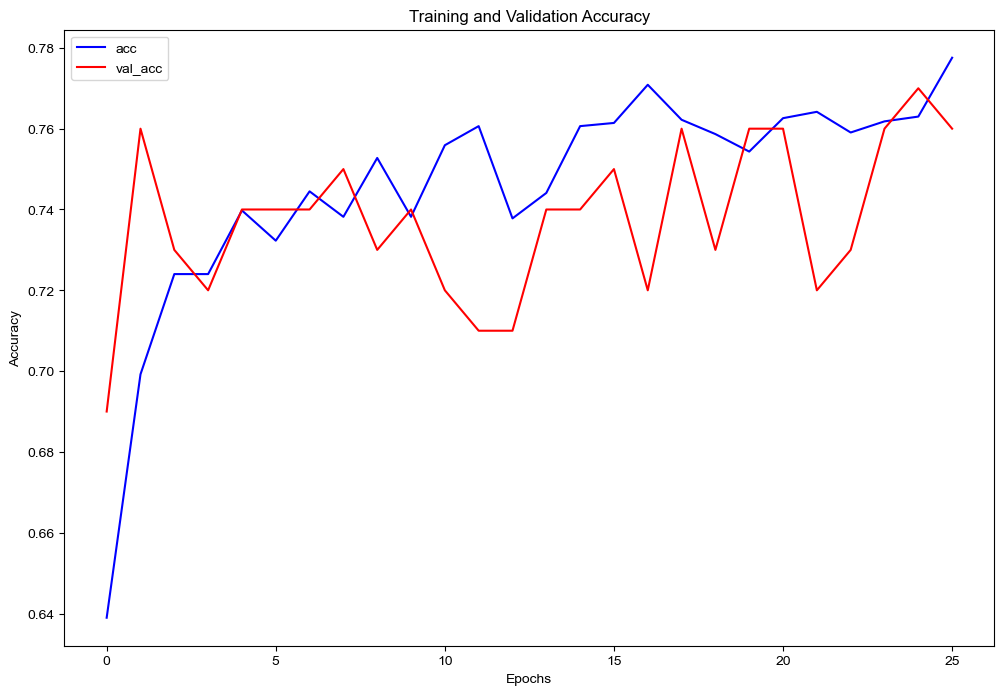

In [61]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=history_df.loc[:, ["acc", "val_acc"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation Loss')

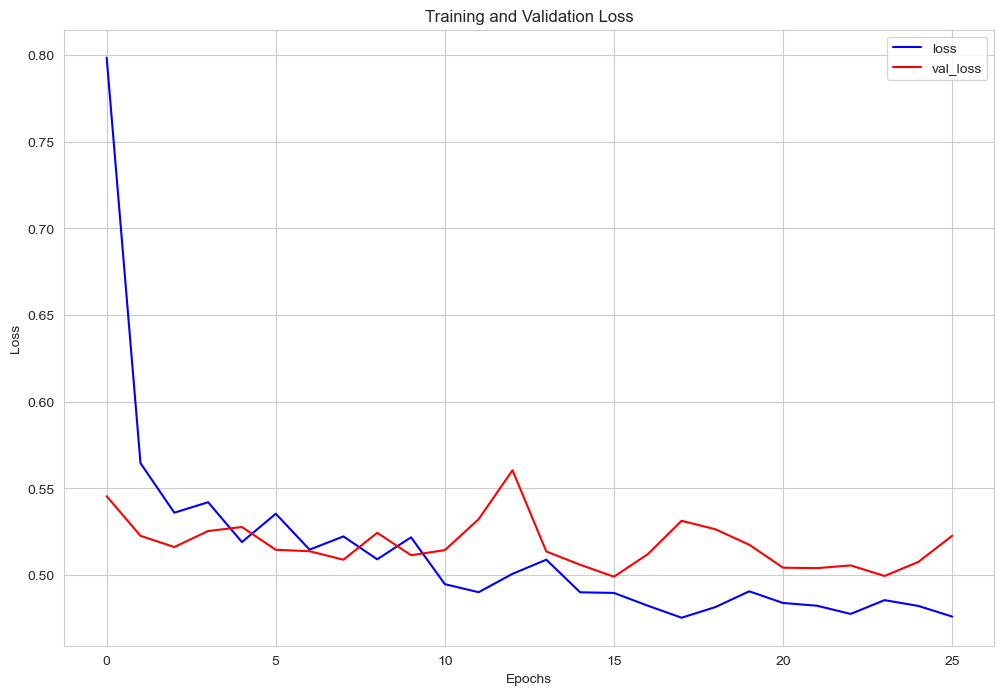

In [62]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=history_df.loc[:, ["loss", "val_loss"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")